In [1]:
# Libraries
import random
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib
import seaborn as sns

In [2]:
# global and final variables
suits = ["Spades", "Clubs", "Diamonds", "Hearts"]

STAND = 0
HIT = 1

LOST = -1
WIN = 1
DRAW = 0

In [4]:
# card object that holds suit, card attribute (A, 1-10 or J,Q,K) and value of card
class Card:
    def __init__(self, suit, att, val):
        self.suit = suit
        self.attribute = att
        self.value = val

    def show(self):
        if self.attribute == 0:
             print("{} of {}".format("Ace", self.suit))
        elif self.attribute == 11:
            print("{} of {}".format("Jack", self.suit))
        elif self.attribute == 12:
            print("{} of {}".format("Queen", self.suit))
        elif self.attribute == 13:
            print("{} of {}".format("King", self.suit))
        else:
            print("{} of {}".format(self.attribute, self.suit))
    
    def setValue(self, val):
        self.value = val

In [5]:
class Deck:
    def __init__(self):
        self.cards = []
        self.build ()

    def build(self):
        for suit in suits:
            for v in range(0, 13) :
                if v == 0: # if card is Ace set default value to 1
                    self.cards.append(Card(suit, v, 1))
                elif v <= 9: # if card is 2 - 10
                    self.cards.append(Card(suit, v+1, v + 1))
                else: # if card is picture card
                    self.cards.append(Card(suit, v+1, 10))
                
    def show(self):
        for c in self.cards:
            c.show()
            
    def shuffle(self):
        for i in range(len(self.cards) - 1, 0, -1):
            r = random.randint(0, i)
            self.cards[i], self.cards[r] = self.cards[r] , self.cards[i]
            
    def drawCard(self):
        return self.cards.pop()  

In [6]:
class Player:
    def __init__(self):
        self.hand = []
        self.ace11 = False

    def sumOfCards(self):
        total = 0 
        for card in self.hand:
            total += card.value
        return total
        
    def draw(self, deck):
        tempSum = 0
        card = deck.drawCard()
        # if ace and sum is less than 10, use ace as 11
        if card.value == 1 and self.sumOfCards() < 11:
            card.setValue(11)
            self.ace11 = True
        else:
            tempSum = self.sumOfCards() + card.value
            # if sum is over 11 and has ace in hand, use ace as 1
            if tempSum > 21 and self.ace11 == True:
                for tempCard in self.hand:
                    if tempCard.value == 11:
                        tempCard.setValue(1)
                self.ace11 = False
        return self.hand.append(card)
    
    def showHand(self):
        for card in self.hand:
            card.show()

In [7]:
#Storing the state-action pairs by making use of a dictionary made out of (state,action) = value where state is in form ((PlayerSum,DealerCard,ace))
StateActionValues = {}
def InitialiseQvalues():
    for PlayerSum in range(12, 21):
        for DealerCard in range(2, 12):
            for ace in [True, False]:
                s = (PlayerSum, DealerCard, ace)
                for a in [HIT, STAND]:
                    StateActionValues[(s, a)] = [0, 0]

#To find the q(S,a) = [value,count] values and counts(the number of time an action was selected in the state) search the dictionary 
#Ex. StateActionValues[((12,3,True),STAND)] 

In [8]:
def updateQvalues(QvaluesToUpdate, R):
    for s in QvaluesToUpdate:
        StateActionValues[s][1] += 1
        N = StateActionValues[s][1]
        StateActionValues[s][0] = StateActionValues[s][0] + (1/N)*(R-StateActionValues[s][0])
#updateQvalues([((12,3,True),STAND),((12,4,True),STAND)],0.5)

In [9]:
#function for Monte Carlo On-Policy Exploring Start
def MCExploring(state, currentEpi):
    sumOf = state[0]
    if sumOf < 12:
        return HIT
    if sumOf == 21:
        return STAND
    k = episode
    #here is where RL is used to decide whether to hit or stand (depending on the state)
    #make decision from policy
    if len(currentEpi) == 0:#this is the first state of the episode hence get a random action
        a = random.randint(STAND, HIT)
    else: #use policy (with probability e choose a random action)
        e = 1/k
        choice = [0, 1] #0 means random value, 1 get best value 
        policy = random.choices(choice, weights = (e, 1 - e), k = 1)
        if policy == 0:
            a = random.randint(STAND, HIT)
        else:
            #choose best q value action
            if StateActionValues[(state,HIT)][0] >= StateActionValues[(state,STAND)][0]:
                a = HIT
            else:
                a = STAND
    currentEpi.append((state,a))
    return a
#function for Monte Carlo On-Policy Exploring Start
def MC(state, currentEpi, E): #Will take 3 values 0,1,2 where 0=1/k, 1=e^-k/1000 2=e^-k/10000
    sumOf = state[0]
    if sumOf < 12:
        return HIT
    if sumOf == 21:
        return STAND
    k = episode
    #here is where RL is used to decide whether to hit or stand (depending on the state)
    #use policy (with probability e choose a random action)
    if E == 1:#get greedy policy
        e = 1/k
    elif E == 2:
        r = -k/1000
        e = np.exp(r)
    else:
        r = -k/10000
        e = np.exp(r)
    choice = [0,1] #0 means random value, 1 get best value 
    policy = random.choices(choice, weights=(e, 1 - e), k = 1)
    if policy == 0:
        a = random.randint(0, 1)
    else:
        #choose best q value action
        if StateActionValues[(state,HIT)][0] >= StateActionValues[(state,STAND)][0]:
            a = HIT
        else:
            a = STAND
    currentEpi.append((state,a))
    return a

In [10]:
#Function for sarsa
def sarsa(state, currentEpi, E):
    sumOf = state[0]
    if sumOf < 12:
        return HIT
    if sumOf == 21:
        return STAND
    k = episode
    
    if E == 1:
        e = 0.1
    elif E == 2:
        e = 1/k
    elif E == 3:
        r = -k/1000
        e = np.exp(r)
    elif E == 4:
        r = -k/10000
        e = np.exp(r)
    else:
        print("Invalid E choice.")
        return None
        
    choice = [0,1] #0 means random value, 1 get best value 
    policy = random.choices(choice, weights=(e, 1 - e), k = 1)
    if policy == 0:
        a = random.randint(STAND, HIT)
    else:
        #choose best q value action
        if StateActionValues[(state,HIT)][0] >= StateActionValues[(state,STAND)][0]:
            a = HIT
        else:
            a = STAND
    currentEpi.append((state,a))
    return a

In [11]:
def qLearning(state,currentEpi):
    sumOf = state[0]
    if sumOf < 12:
        return HIT
    if sumOf == 21:
        return STAND
    #choose best Q value action
    if StateActionValues[(state,HIT)][0] >= StateActionValues[(state,STAND)][0]:
        a = HIT
    else:
        a = STAND
    currentEpi.append((state,a))
    return a

In [12]:
#Function to Update State-action values according to SARSA  
def sarsaUpdateValues(currQ, nextQ, R, isFinalState):
    StateActionValues[currQ][1] += 1
    N = StateActionValues[currQ][1]
    a = 1/(N + 1)
    
    if isFinalState:#if final state there is no lookahead state we can go to
        StateActionValues[currQ][0] = StateActionValues[currQ][0] + (a * (R - StateActionValues[currQ][0]))
    else:
        StateActionValues[currQ][0] = StateActionValues[currQ][0] + (a * (R + StateActionValues[nextQ][0] - StateActionValues[currQ][0]))

In [13]:
# function that simulates a blackjack game using MC explore
def playBlackjackMCExplore(epi):
        # setting up game enviroment
        playingCards = Deck()
        playingCards.shuffle()
        dealer = Player()
        user = Player()

        # user draws 2 cards and dealer draw a card
        user.draw(playingCards)
        user.draw(playingCards)
        dealer.draw(playingCards)

        # Rl model decision
        currentEpi = []
        state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
        while(MCExploring(state,currentEpi) != STAND):
            user.draw(playingCards)
            state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)#every time we draw a card the state changes
            if user.sumOfCards() > 21:
                updateQvalues(currentEpi,LOST)
                return LOST
        #Stand was chosen 
        # dealer policy (play till sum is more than 16)
        while(dealer.sumOfCards() < 17):
            dealer.draw(playingCards)

        dealerFinalSum = dealer.sumOfCards()
        playerFinalSum = user.sumOfCards()
        #print("\nDealer")
        #print(dealerFinalSum)
        #dealer.showHand()
        #print("\nUser")
        #print(playerFinalSum)
        #user.showHand()
         
        result = 3 #game result
        if dealerFinalSum > 21:
            result = WIN
        elif dealerFinalSum == playerFinalSum:
            result = DRAW
        elif dealerFinalSum > playerFinalSum:
            result = LOST
        else:
            result = WIN
        updateQvalues(currentEpi,result)
        return result

In [14]:
# function that simulates a blackjack game using MC
def playBlackjackMC(epi,Emode):
        # setting up game enviroment
        playingCards = Deck()
        playingCards.shuffle()
        dealer = Player()
        user = Player()

        # user draws 2 cards and dealer draw a card
        user.draw(playingCards)
        user.draw(playingCards)
        dealer.draw(playingCards)

        # Rl model decision
        currentEpi = []
        state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
        while(MC(state,currentEpi,Emode) != STAND):
            user.draw(playingCards)
            state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
            if user.sumOfCards() > 21:
                updateQvalues(currentEpi,LOST)
                return LOST
        #Stand was chosen 
        # dealer policy (play till sum is more than 16)
        while(dealer.sumOfCards() < 17):
            dealer.draw(playingCards)

        dealerFinalSum = dealer.sumOfCards()
        playerFinalSum = user.sumOfCards()
        #print("\nDealer")
        #print(dealerFinalSum)
        #dealer.showHand()
        #print("\nUser")
        #print(playerFinalSum)
        #user.showHand()
         
        result = 3 #game result
        if dealerFinalSum > 21:
            result = WIN
        elif dealerFinalSum == playerFinalSum:
            result = DRAW
        elif dealerFinalSum > playerFinalSum:
            result = LOST
        else:
            result = WIN
        updateQvalues(currentEpi,result)
        return result

In [15]:
# function that simulates a blackjack game
def playBlackjackSarsa(epi, Emode):
        # setting up game enviroment
        playingCards = Deck()
        playingCards.shuffle()
        dealer = Player()
        user = Player()

        # user draws 2 cards and dealer draw a card
        user.draw(playingCards)
        user.draw(playingCards)
        dealer.draw(playingCards)

        # Rl model decision
        currentEpi = []
        state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
        while(sarsa(state,currentEpi,Emode) != STAND):
            user.draw(playingCards)
            state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
            if user.sumOfCards() > 21:
                sarsaUpdateValues(currentEpi[-1], None, LOST, True)
                return LOST
            if len(currentEpi) == 2:#update after every step 
                sarsaUpdateValues(currentEpi[-2], currentEpi[-1], 0, False)
                currentEpi.pop(0)
        #Stand was chosen 
        
        # dealer policy (play till sum is more than 16)
        while(dealer.sumOfCards() < 17):
            dealer.draw(playingCards)

        dealerFinalSum = dealer.sumOfCards()
        playerFinalSum = user.sumOfCards()
        #print("\nDealer")
        #print(dealerFinalSum)
        #dealer.showHand()
        #print("\nUser")
        #print(playerFinalSum)
        #user.showHand()
         
        result = 3 #game result
        if dealerFinalSum > 21:
            result = WIN
        elif dealerFinalSum == playerFinalSum:
            result = DRAW
        elif dealerFinalSum > playerFinalSum:
            result = LOST
        else:
            result = WIN
        if len(currentEpi) > 0:#it might be the case that the player has 21 from the two cards dealt 
            sarsaUpdateValues(currentEpi[-1], None, result, True)
        return result

In [16]:
# function that simulates a blackjack game
def playBlackjackQlearn(epi):
        # setting up game enviroment
        playingCards = Deck()
        playingCards.shuffle()
        dealer = Player()
        user = Player()

        # user draws 2 cards and dealer draw a card
        user.draw(playingCards)
        user.draw(playingCards)
        dealer.draw(playingCards)

        # Rl model decision
        currentEpi = []
        state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
        while(qLearning(state,currentEpi) != STAND):
            user.draw(playingCards)
            state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
            if user.sumOfCards() > 21:
                sarsaUpdateValues(currentEpi[-1], None, LOST, True)
                return LOST
            if len(currentEpi) == 2:#update after every step 
                sarsaUpdateValues(currentEpi[-2], currentEpi[-1], 0, False)
                currentEpi.pop(0)
        # dealer policy (play till sum is more than 16)
        while(dealer.sumOfCards() < 17):
            dealer.draw(playingCards)

        dealerFinalSum = dealer.sumOfCards()
        playerFinalSum = user.sumOfCards()
        #print("\nDealer")
        #print(dealerFinalSum)
        #dealer.showHand()
        #print("\nUser")
        #print(playerFinalSum)
        #user.showHand()
         
        result = 3 #game result
        if dealerFinalSum > 21:
            result = WIN
        elif dealerFinalSum == playerFinalSum:
            result = DRAW
        elif dealerFinalSum > playerFinalSum:
            result = LOST
        else:
            result = WIN
        if len(currentEpi) > 0:#it might be the case that the player has 21 from the two cards dealt 
            sarsaUpdateValues(currentEpi[-1], None, result, True)
        return result

In [18]:
InitialiseQvalues()
#for Q learning Off-Policy
n = 1000000
Score = [0, 0, 0] #keep count of how many times the player wins, draws or loses
for episode in range(1, n + 1):#repeat the process for n episodes
    if episode < 900000:
        result = playBlackjackSarsa(episode,4)#learn Sarsa Policy
    else:
        result = playBlackjackQlearn(episode)#Q learning Off-sarsa Policy 
        if result == WIN:
            Score[0] += 1
        elif result == DRAW:
            Score[1] += 1
        else:
            Score[2] += 1
mWin = Score[0]/100000
mDraw = Score[1]/100000
mLose = Score[2]/100000
daelerAdv = (mLose-mWin)/(mLose+mWin)
print("mean wins",mWin)
print("mean draws",mDraw)
print("mean loses",mLose)
print("dealer advantage",daelerAdv)
Score

mean wins 0.42683
mean draws 0.07727
mean loses 0.49591
dealer advantage 0.07486399202375536


[42683, 7727, 49591]

In [24]:
InitialiseQvalues()
#For any on-policy model
n = 1000000
Score = [0, 0, 0] #keep count of how many times the player wins, draws or loses
for episode in range(1, n + 1):#repeat the process for n episodes
    #result = playBlackjackMCExplore(episode)
    #result = playBlackjackMC(episode,1)
    result = playBlackjackMC(episode,2)
    #result = playBlackjackMC(episode,3)
    #result = playBlackjackSarsa(episode,1)
    #result = playBlackjackSarsa(episode,2)
    #result = playBlackjackSarsa(episode,3)
    #result = playBlackjackSarsa(episode,4)
    if(episode>900000):
        if result == WIN:
            Score[0] += 1
        elif result == DRAW:
            Score[1] += 1
        else:
            Score[2] += 1

mWin = Score[0]/100000
mDraw = Score[1]/100000
mLose = Score[2]/100000
daelerAdv = (mLose-mWin)/(mLose+mWin)
print("mean wins",mWin)
print("mean draws",mDraw)
print("mean loses",mLose)
print("dealer advantage",daelerAdv)

Score

mean wins 0.36793
mean draws 0.06925
mean loses 0.56282
dealer advantage 0.20939027665860865


[36793, 6925, 56282]

In [25]:
#BLackJack Stategy Table
dataWithAce = []
index = 0
for playerSum in range(20, 11, -1):
    dataWithAce.append([])
    for dealerCard in range(2,12):
        if(StateActionValues[((playerSum,dealerCard,True),HIT)][0] >= StateActionValues[((playerSum,dealerCard,True),STAND)][0]):
            dataWithAce[index].append('H')
        else:
            dataWithAce[index].append('S')
    index += 1

dataNoAce = []
index = 0
for playerSum in range(20, 11, -1):
    dataNoAce.append([])
    for dealerCard in range(2,12):
        if(StateActionValues[((playerSum,dealerCard,False),HIT)][0] >= StateActionValues[((playerSum,dealerCard,False),STAND)][0]):
            dataNoAce[index].append('H')
        else:
            dataNoAce[index].append('S')
    index += 1
# Create DataFrame object from a list of tuples
StrategyWithAce = pd.DataFrame(dataWithAce, columns = ['2' , '3', '4' , '5', '6','7','8','9','10','A'], index=['20', '19', '18' , '17' , '16' , '15', '14', '13', '12'])
Strategy = pd.DataFrame(dataNoAce, columns = ['2' , '3', '4' , '5', '6','7','8','9','10','A'], index=['20', '19', '18' , '17' , '16' , '15', '14', '13', '12'])
print("Q-Learning 𝜖 = 𝑒^(−𝑘/10000)")
print("With a usable Ace:")
print(tabulate(StrategyWithAce, headers = 'keys', tablefmt = 'psql'))
print("Without a usable Ace:")
print(tabulate(Strategy, headers = 'keys', tablefmt = 'psql'))

Q-Learning 𝜖 = 𝑒^(−𝑘/10000)
With a usable Ace:
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
|----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----|
| 20 | S   | S   | S   | S   | H   | H   | H   | S   | S    | S   |
| 19 | S   | H   | H   | H   | S   | S   | S   | S   | S    | S   |
| 18 | H   | H   | S   | S   | S   | S   | H   | H   | H    | S   |
| 17 | S   | S   | H   | S   | H   | H   | H   | H   | H    | S   |
| 16 | S   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 14 | H   | H   | S   | H   | H   | S   | H   | H   | H    | H   |
| 13 | H   | H   | H   | H   | S   | H   | H   | H   | H    | S   |
| 12 | S   | H   | S   | H   | H   | S   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
Without a usable Ace:
+----+-----+-----+-----+-----+-----+-----+-----

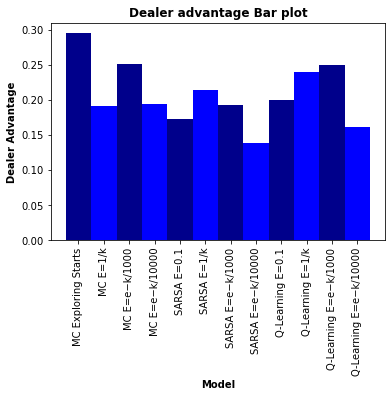

In [28]:
import matplotlib.pyplot as plt
 
# x-coordinates of left sides of bars
left = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
 
# heights of bars
height = [0.29472, 0.19062, 0.25084, 0.19327, 0.17261, 0.21380, 0.19234, 0.13855, 0.19940, 0.23997, 0.24930, 0.16065]
 
# labels for bars
tick_label = ['MC Exploring Starts', 'MC E=1/k', 'MC E=e−k/1000', 'MC E=e−k/10000', 'SARSA E=0.1', 'SARSA E=1/k', 'SARSA E=e−k/1000', 'SARSA E=e−k/10000', 'Q-Learning E=0.1', 'Q-Learning E=1/k',  'Q-Learning E=e−k/1000', 'Q-Learning E=e−k/10000']
 
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label, width = 2, color = ['darkblue', 'blue'])
 
# naming the x-axis
plt.xlabel('Model',fontweight='bold')
# naming the y-axis
plt.ylabel('Dealer Advantage',fontweight='bold')
# plot title
plt.title('Dealer advantage Bar plot',fontweight='bold')
plt.xticks(rotation = 90)
# function to show the plot

plt.show()